In [1]:
!pip install langdetect
!pip install tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=a88e534fd03c06bcc09d8817153d43fd4c38de2d2b05cb893cc2904341bcadef
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langdetect import detect




## Initial Data Processing
The preprocessing begins by loading train_data from data_unsupervised.csv. Duplicate entries are removed to ensure data uniqueness, and indices are reset. A preview of train_data is displayed, confirming successful data loading and initial cleanup.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
train_data=pd.read_csv("/content/drive/MyDrive/Reddit/data_unsupervised.csv", encoding="utf8")

train_data = train_data.drop_duplicates()
train_data.reset_index(drop=True, inplace=True)


Mounted at /content/drive


In [4]:
train_data.tail()

author          subreddit   created_utc  \
851804      friedeggzohyeah  TrollXChromosomes  1.391213e+09   
851805      im_a_leadfarmer         psychology  1.391213e+09   
851806  misandrical_unicorn            atheism  1.391213e+09   
851807             LevyWife           AskWomen  1.391213e+09   
851808             Simbablk                sex  1.391213e+09   

                                                     body  
851804  Oh god I my mom has celiac and has to buy insa...  
851805  Great, I guess i won't skip my 4th one at work...  
851806  [k](http://gifrific.com/wp-content/uploads/201...  
851807                     this is not a yahoo chat room.  
851808  Perhaps sitting on the toilet and trying to "p...

## Data Uniqueness and Completeness Analysis
The dataset's diversity and completeness are assessed by calculating the number of unique values in key attributes: authors, subreddits, and comment bodies. Additionally, a check for missing data across all columns is performed using isnull().sum(). These statistics are crucial for understanding the dataset's breadth and ensuring data quality.

In [5]:
# How many different attribute values you observe in each features? Is there any missing data?

unique_authors=train_data.author.unique().shape[0]
unique_subreddits=train_data.subreddit.unique().shape[0]
unique_bodies=train_data.body.unique().shape[0]
missing_data = train_data.isnull().sum()
print("Unique authors:", unique_authors)
print("Unique subreddits:", unique_subreddits)
print("Unique comment bodies:", unique_bodies)
print("\nMissing data in each column:\n", missing_data)

Unique authors: 15000
Unique subreddits: 3970
Unique comment bodies: 828128

Missing data in each column:
 author         0
subreddit      0
created_utc    0
body           1
dtype: int64


In [6]:
train_data = train_data.dropna(subset=['body'])

# Verify if the missing data has been dropped
missing_data_after = train_data.isnull().sum()
print("\nMissing data in each column after cleaning:\n", missing_data_after)


Missing data in each column after cleaning:
 author         0
subreddit      0
created_utc    0
body           0
dtype: int64


## Empirical Distribution of Comment Lengths
The length of each comment is calculated (excluding spaces) to analyze the distribution of comment lengths in the dataset. The empirical cumulative distribution function (eCDF) is plotted for the log-transformed lengths, highlighting the quartiles. This analysis provides insights into the typical length of comments and their variability.

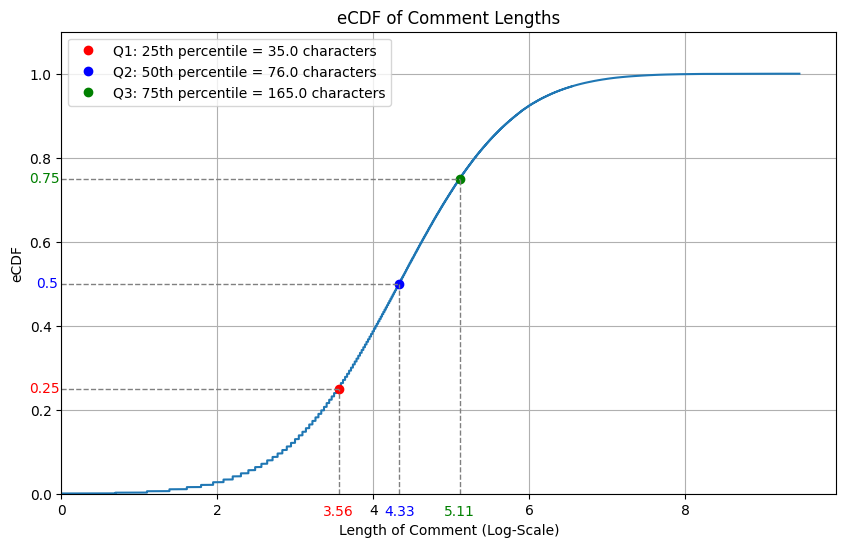

In [7]:
# (Referring to textual features) How does the empirical distribution of the number of characters in
# each comment look like?
train_data['comment_length']=train_data['body'].str.replace(' ','').apply(len)
longest_comment = train_data['comment_length'].max()
log_comment_length = np.log(train_data['comment_length'])

import statsmodels.distributions.empirical_distribution
ecdf = statsmodels.distributions.empirical_distribution.ECDF(log_comment_length)

plt.figure(figsize=(10, 6))
plt.plot(ecdf.x, ecdf.y)
plt.title('eCDF of Comment Lengths')
plt.xlabel('Length of Comment (Log-Scale)')
plt.ylabel('eCDF')

Q1 = np.interp(0.25, ecdf.y, ecdf.x)
Q2 = np.interp(0.5, ecdf.y, ecdf.x)
Q3 = np.interp(0.75, ecdf.y, ecdf.x)

point_label = f'Q1: 25th percentile = {round(np.exp(Q1),2)} characters'
plt.plot(Q1, 0.25, 'ro', label=point_label)
plt.plot([Q1, Q1], [0, 0.25], 'gray', linestyle='--',linewidth=1)
plt.plot([0, Q1], [0.25, 0.25], 'gray', linestyle='--',linewidth=1)
plt.annotate(f'{Q1:.2f}', (Q1, 0),
             textcoords="offset points", xytext=(0, -8), ha='center', va='top',color='red')
plt.annotate('0.25', xy=(0, 0.25), xytext=(-12, 0),
             textcoords="offset points", ha='center', va='center', color='red')

point_label = f'Q2: 50th percentile = {round(np.exp(Q2),2)} characters'
plt.plot(Q2, 0.5, 'bo', label=point_label)
plt.plot([Q2, Q2], [0, 0.5], 'gray', linestyle='--',linewidth=1)
plt.plot([0, Q2], [0.5, 0.5], 'gray', linestyle='--',linewidth=1)
plt.annotate(f'{Q2:.2f}', (Q2, 0),
             textcoords="offset points", xytext=(0, -8), ha='center', va='top',color='blue')
plt.annotate('0.5', xy=(0, 0.5), xytext=(-10, 0),
             textcoords="offset points", ha='center', va='center', color='blue')

point_label = f'Q3: 75th percentile = {round(np.exp(Q3),2)} characters'
plt.plot(Q3, 0.75, 'go', label=point_label)
plt.plot([Q3, Q3], [0, 0.75], 'gray', linestyle='--',linewidth=1)
plt.plot([0, Q3], [0.75, 0.75], 'gray', linestyle='--',linewidth=1)
plt.annotate(f'{Q3:.2f}', (Q3, 0),
             textcoords="offset points", xytext=(0, -8), ha='center', va='top',color='green')
plt.annotate('0.75', xy=(0, 0.75), xytext=(-12, 0),
             textcoords="offset points", ha='center', va='center', color='green')


plt.legend()
plt.xlim([0,None])
plt.ylim([0, 1.1])
plt.grid(True)
plt.show()


## Language Detection and Text Processing

In the preprocessing pipeline, each comment's language is identified, filtering out non-English comments to focus the analysis on English ones. A pie chart shows the language distribution, emphasizing English prevalence and any language detection errors. English comments are then normalized (converted to lowercase), lemmatized, and stripped of stop words using spaCy, thus refining the text for effective feature extraction.




In [8]:
#Are there only comments in English? usig googletrans wasnt efficient at all, it took 20 hrs so ifind out detect() method which takes only 20 minutes
from tqdm import tqdm # this is a library for tracking a loop just not to live in a vague world

languages=[]
errors_rows=[]
x = len(train_data['body'])
for i in tqdm(range(len(train_data['body']))):
    try:
        lang = detect(str(train_data['body'].iloc[i]))
    except Exception as e:
        lang = 'error'
        errors_rows.append(i)
    languages.append(lang)






100%|██████████| 851808/851808 [1:23:14<00:00, 170.56it/s]


In [10]:
english_comments = languages.count('en')
total_comments = len(languages)

In [11]:
english_comments = languages.count('en')
total_comments = len(languages)

In [ ]:
print(errors_rows)

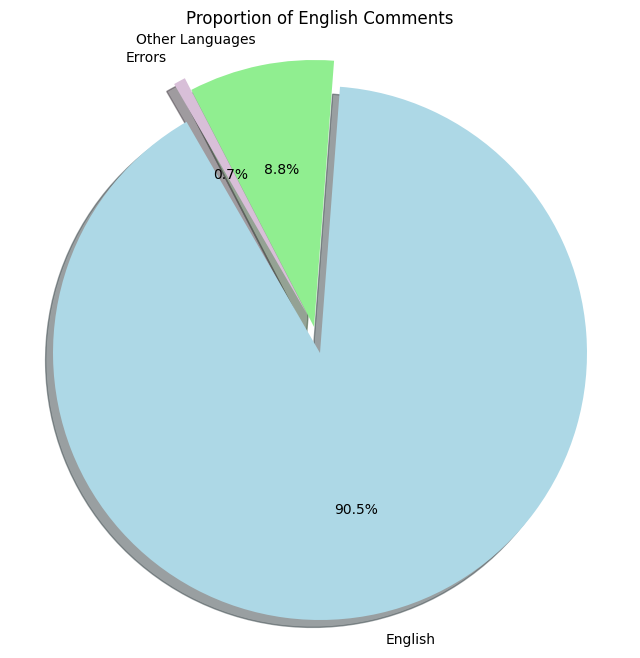

In [12]:
labels = ['English', 'Other Languages','Errors']
sizes = [english_comments, total_comments - english_comments-len(errors_rows),len(errors_rows)]
colors = ['lightblue', 'lightgreen','thistle']
explode = (0.1, 0,0.05)

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=120)
plt.axis('equal')
plt.title('Proportion of English Comments')
plt.show()

In [23]:
train_data['language'] = languages


train_data_en = train_data[train_data['language'] == 'en']


In [24]:
train_data_en['body'] = train_data_en['body'].str.lower()
train_data_en.head()

<ipython-input-24-a0f41ac069ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_en['body'] = train_data_en['body'].str.lower()


author        subreddit   created_utc  \
0  ejchristian86  TwoXChromosomes  1.388534e+09   
1      ZenDragon           gaming  1.388534e+09   
3   hentercenter     stlouisblues  1.388534e+09   
4   rick-o-suave             army  1.388534e+09   
5   olivermihoff    AdviceAnimals  1.388534e+09   

                                                body  comment_length language  
0  i hadn't ever heard of them before joining thi...             914       en  
1                at 7680 by 4320 with 64x aa, right?              28       en  
3                    damn that was a good penalty :(              25       en  
4  i swore into dep on 6-oct and i left 5-nov und...             164       en  
5  not that it's ever to be equated because it's ...             291       en

In [25]:
import spacy
import pandas as pd
from scipy import sparse
from sklearn.utils import shuffle

# Load spaCy's English language model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Function to preprocess text: remove stop words and lemmatize (reduce to root or bas form)
def preprocess_text(texts):
    processed_texts = []
    for doc in nlp.pipe(texts):
        tokens = [token.lemma_ for token in doc if not token.is_stop]
        processed_texts.append(' '.join(tokens))
    return processed_texts

# apply to comments
train_data_en['body'] = preprocess_text(train_data_en['body'])

<ipython-input-25-18f5f44822e4>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_en['body'] = preprocess_text(train_data_en['body'])


In [26]:
train_data_en.dropna(subset=['body'], inplace=True)
print(len(train_data_en))

770656


<ipython-input-26-1804eb30192a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_en.dropna(subset=['body'], inplace=True)


### Text Feature Extraction with DistilBERT

We employ DistilBERT for feature extraction to transform the textual comments into a numerical form that can be processed by machine learning algorithms. The procedure is as follows:

1. **Tokenization**: Comments are tokenized to ensure they fit within DistilBERT's 512-token limit.
2. **DistilBERT Embeddings**: We initialize DistilBERT and encode the comments on a GPU for efficiency, obtaining a 768-dimensional vector representation for each comment.
3. **Processing**: We process comments recording their original indices to keep track of each comment's origin.
4. **Embedding Storage**: The resulting embeddings and their corresponding indices are stored in a Pandas DataFrame, ready for downstream analysis.

This distilled feature extraction approach effectively condenses the rich semantic information of the comments into dense numerical vectors, setting the stage for robust unsupervised learning tasks.


In [27]:
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertModel
import torch


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


df = train_data_en


tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


def count_tokens(text):
    return len(tokenizer.tokenize(text))

# Count tokens for each comment
df['token_count'] = df['body'].apply(count_tokens)

# Filter comments with less than 512 tokens to be compatible with distilbert
filtered_df = df[df['token_count'] < 512]

# Initialize DistilBERT model
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
device = get_device()
model.to(device)

# function to encode comments
def encode_comments(text):
    # Tokenize and encode the text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get the embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# Vectorize the comments and keep track of the original indices
batch_size = 128
embeddings = []
original_indices = []

for i in range(0, len(filtered_df), batch_size):
    batch_texts = filtered_df['body'].iloc[i:i+batch_size].tolist()
    batch_indices = filtered_df.index[i:i+batch_size].tolist()
    batch_embeddings = [encode_comments(text) for text in batch_texts]
    embeddings.extend(batch_embeddings)
    original_indices.extend(batch_indices)



<ipython-input-27-7d28f62530b2>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['token_count'] = df['body'].apply(count_tokens)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [28]:
embeddings_2d = np.array(embeddings).reshape(-1, 768)
embeddings_df = pd.DataFrame(embeddings_2d)
embeddings_df['original_index'] = original_indices

In [29]:
import numpy as np

# Randomly sample 10,000 embeddings from the dataset for manageable computation
# 'replace=False' ensures that we don't select the same embedding more than once

#set seed for reproducibility
np.random.seed(42)

# Sample 10k embeddings and their indices
sample_indices = np.random.choice(embeddings_df.index, size=10000, replace=False)
sampled_embeddings = embeddings_df.loc[sample_indices]

sampled_embeddings.to_pickle('sampled_embeddings.pkl')

### Dimensionality Reduction with PCA

Principal Component Analysis (PCA) is utilized to reduce the dimensionality of the feature set obtained from DistilBERT embeddings:

1. **PCA Fit**: The PCA model is fitted to the embeddings with 700 components initially to capture as much variance as possible.
2. **Scree Plot**: A scree plot is generated to visualize the cumulative explained variance, assisting in the selection of the number of components.
3. **Variance Threshold**: After reducing the number of components to 142, we retain a substantial proportion of the variance (over 90%), ensuring that the reduced dataset still captures the essential characteristics of the original data.

This step is crucial to manage computational complexity and prepare the data for clustering analysis.


In [ ]:
sampled_embeddings.head

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


n_components = 700
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(sampled_embeddings.drop('original_index', axis=1, errors='ignore'))

# Get the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_




In [ ]:
# Create a scree plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, n_components + 1), explained_variance_ratio.cumsum(), marker=None, linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

# individual explained variance
plt.twinx()
plt.plot(range(1, n_components + 1), explained_variance_ratio, color='red', marker=None)
plt.ylabel('Explained Variance Ratio per Component', color='red')


plt.show()

In [ ]:
print("Cumulative Variance Explained by each component:")
for i, variance in enumerate(explained_variance_ratio.cumsum()):
    print(f"Component {i+1}: {variance:.4f}")

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


n_components = 142
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(sampled_embeddings.drop('original_index', axis=1, errors='ignore'))

cumulative_variance1 = pca.explained_variance_ratio_.cumsum()


print(f"Cumulative Variance Explained by {n_components} components: {cumulative_variance1[-1]:.4f}")


Cumulative Variance Explained by 142 components: 0.9026


## KMeans Clustering and Elbow Method

We applied KMeans clustering to group our data into clusters by minimizing within-cluster variance. To find the optimal number of clusters, we used the Elbow Method, plotting the within-cluster sum of squares (WCSS) for 2 to 25 clusters.

The 'elbow' in the plot indicates the point where adding more clusters yields diminishing returns. We chose 6 clusters based on this method, as it offers a reasonable trade-off between complexity and the ability to distinguish different groups.

Each data point is now labeled with a cluster number, integrating categorical insights for subsequent analyses.


In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


#  range clusters to try
range_of_clusters = range(2, 26)

wss = []

for n_clusters in range_of_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42,n_init=10)
    clusters = kmeans.fit_predict(X_reduced)


    wss.append(kmeans.inertia_)


    print(f"Number of clusters: {n_clusters}")
    print(f"Within-Cluster Sum of Squares (WSS): {kmeans.inertia_}")





Number of clusters: 2
Within-Cluster Sum of Squares (WSS): 146538.453125
Number of clusters: 3
Within-Cluster Sum of Squares (WSS): 139459.1875
Number of clusters: 4
Within-Cluster Sum of Squares (WSS): 132956.828125
Number of clusters: 5
Within-Cluster Sum of Squares (WSS): 128400.0
Number of clusters: 6
Within-Cluster Sum of Squares (WSS): 125304.421875
Number of clusters: 7
Within-Cluster Sum of Squares (WSS): 122975.640625
Number of clusters: 8
Within-Cluster Sum of Squares (WSS): 121109.9296875
Number of clusters: 9
Within-Cluster Sum of Squares (WSS): 119612.453125
Number of clusters: 10
Within-Cluster Sum of Squares (WSS): 118212.484375
Number of clusters: 11
Within-Cluster Sum of Squares (WSS): 117037.875
Number of clusters: 12
Within-Cluster Sum of Squares (WSS): 115975.9609375
Number of clusters: 13
Within-Cluster Sum of Squares (WSS): 115036.484375
Number of clusters: 14
Within-Cluster Sum of Squares (WSS): 114138.875
Number of clusters: 15
Within-Cluster Sum of Squares (WSS

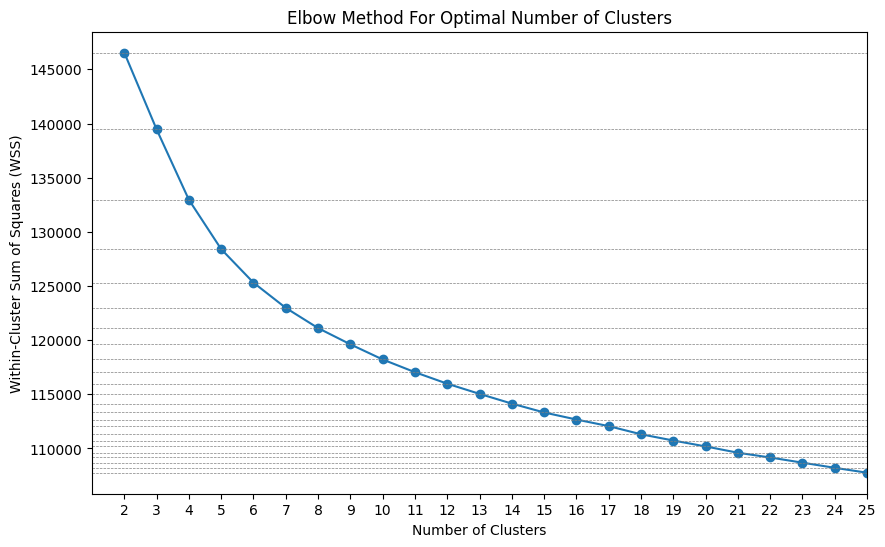

In [32]:
import matplotlib.pyplot as plt

# Plotting  with horizontal  lines
plt.figure(figsize=(10, 6))
plt.plot(range_of_clusters, wss, marker='o', linestyle='-')  # Main line plot for WSS

for i, value in enumerate(wss):
    plt.hlines(y=value, xmin=1, xmax=range_of_clusters[-1], color='gray', linestyles='dashed', lw=0.5)


plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.xticks(range_of_clusters)
plt.xlim([1,25])
plt.show()


In [33]:
#  KMeans with the chosen number of clusters
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(X_reduced)

# Add the cluster assignments to the sampled_embeddings DataFrame
sampled_embeddings['cluster'] = cluster_labels

# Map the 'author' and 'body' (original comment) from filtered_df to sampled_embeddings using the original_index
sampled_embeddings = sampled_embeddings.join(
    filtered_df[['author', 'body']],
    on='original_index'
)

sampled_embeddings = sampled_embeddings[['original_index', 'author', 'body', 'cluster'] + list(range(X_reduced.shape[1]))]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [34]:
sampled_embeddings = sampled_embeddings.join(
    filtered_df[['subreddit']],
    on='original_index'
)

## Empirical Cumulative Distribution Function (ECDF) and Word Cloud Visualization

To understand the spread of our data across the clusters, we calculated the ECDF for the number of unique clusters assigned to each author. This gives us a sense of the diversity in user comments across different clusters.

Subsequently, we visualized the most common words within each cluster using word clouds, highlighting the dominant topics or themes.




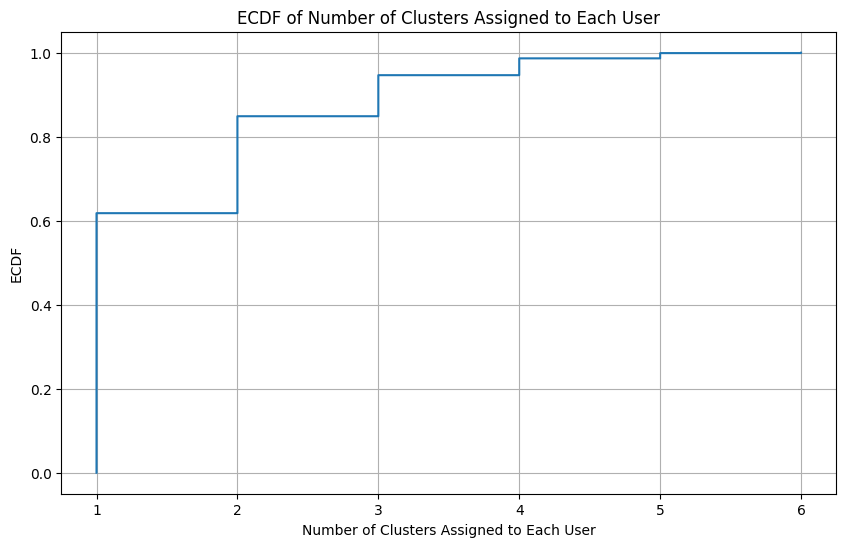

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Group by 'author' and count the unique clusters
user_cluster_distribution = sampled_embeddings.groupby('author')['cluster'].nunique()

ecdf = ECDF(user_cluster_distribution)

# Plot the ECDF
plt.figure(figsize=(10, 6))
plt.step(ecdf.x, ecdf.y, where='post')
plt.xlabel('Number of Clusters Assigned to Each User')
plt.ylabel('ECDF')
plt.title('ECDF of Number of Clusters Assigned to Each User')
plt.grid(True)



In [37]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
n_clusters=6
# Download stopwords from NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to tokenize and remove stopwords
def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
    return filtered_words





[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


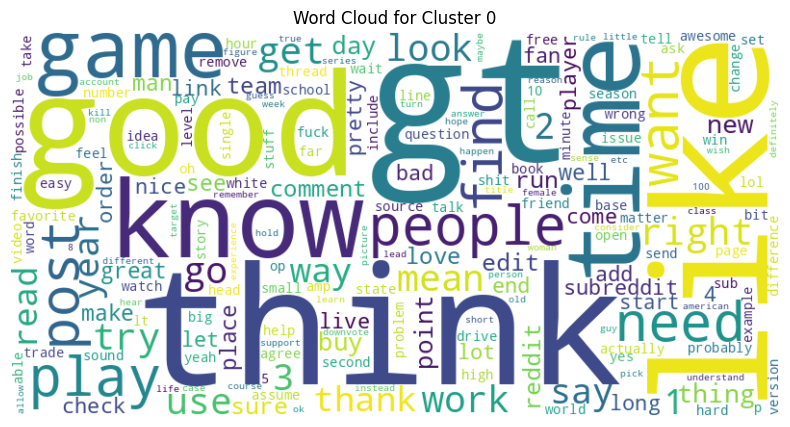

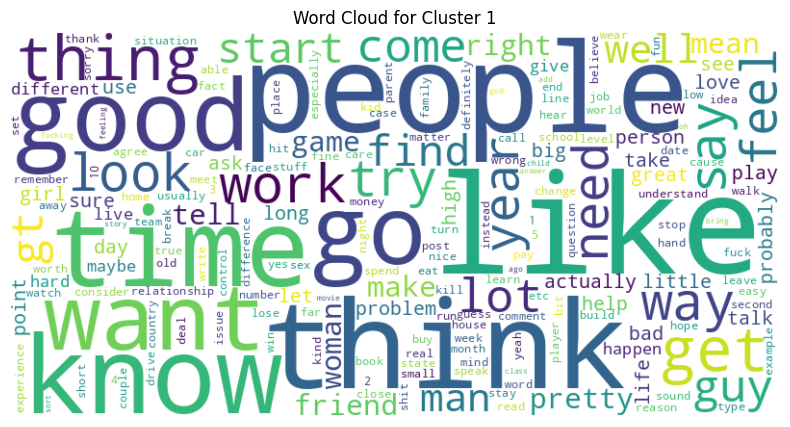

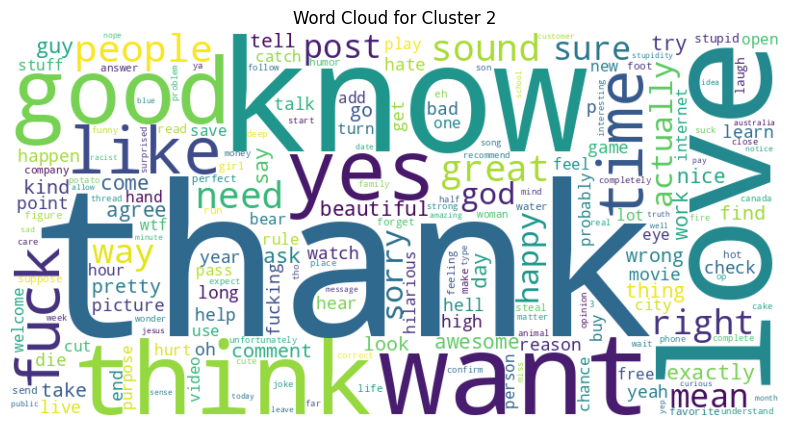

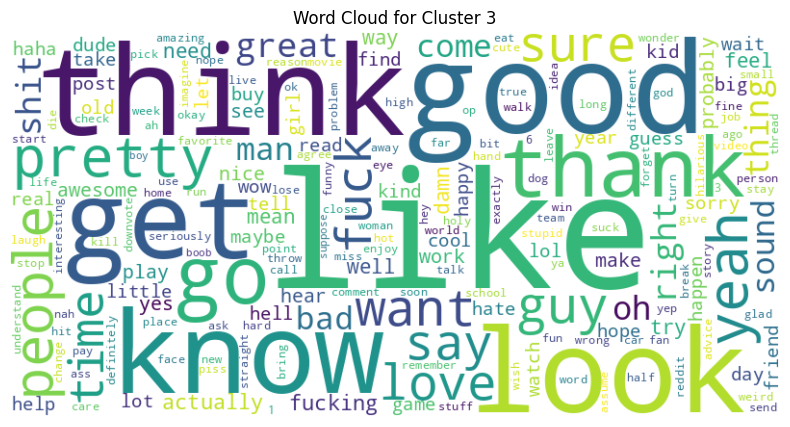

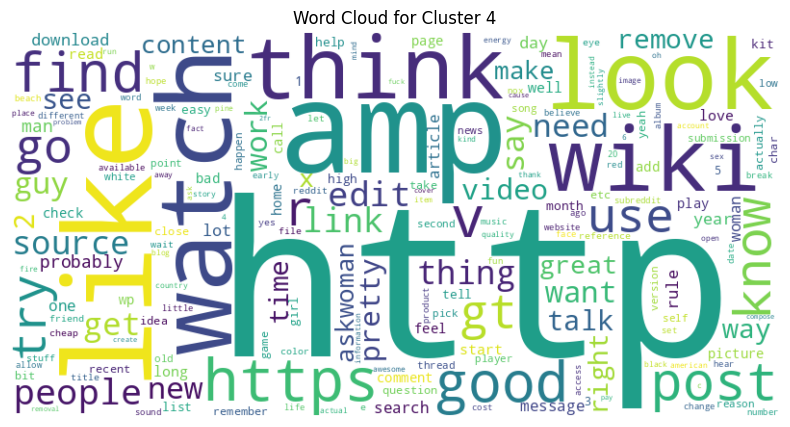

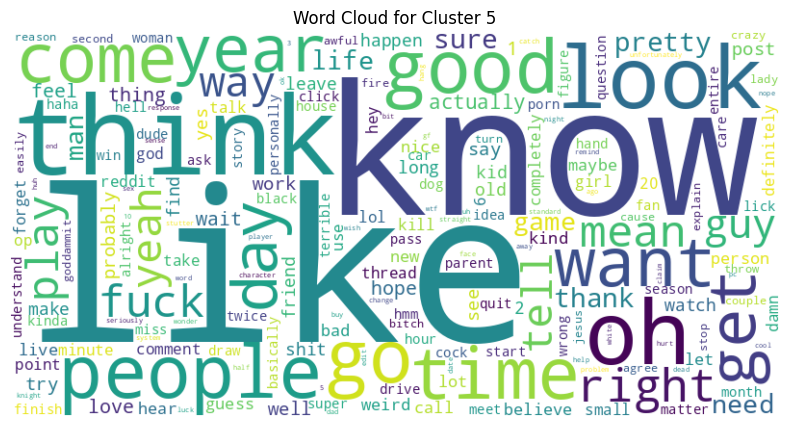

In [38]:
for cluster_num in range(n_clusters):
    # Filter the dataframe for the current cluster
    cluster_comments = sampled_embeddings[sampled_embeddings['cluster'] == cluster_num]['body']

    # Tokenize and remove stopwords
    tokenized_comments = cluster_comments.apply(tokenize_and_remove_stopwords)

    # Flatten the list of tokenized comments and count word frequencies
    word_freq = Counter(word for comment in tokenized_comments for word in comment)

    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Plot cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_num}')
    plt.show()

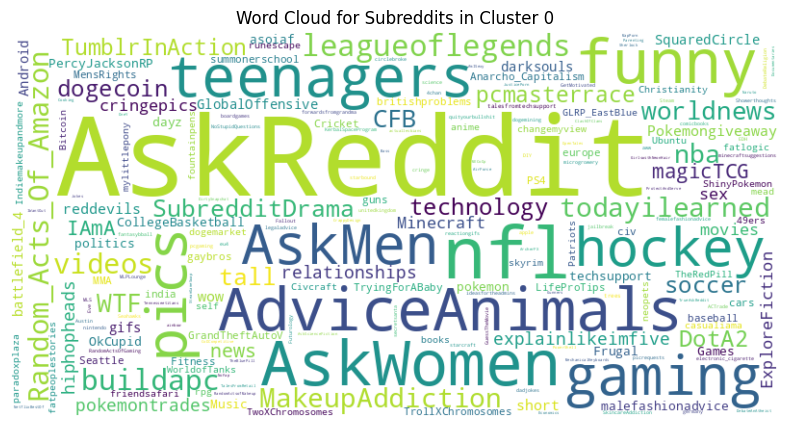

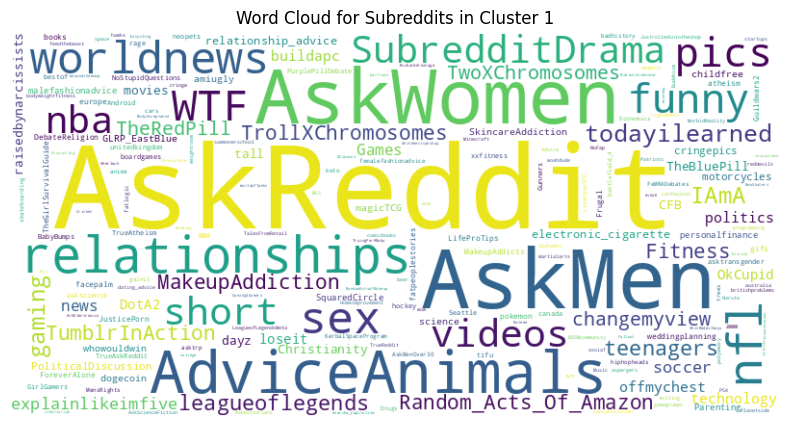

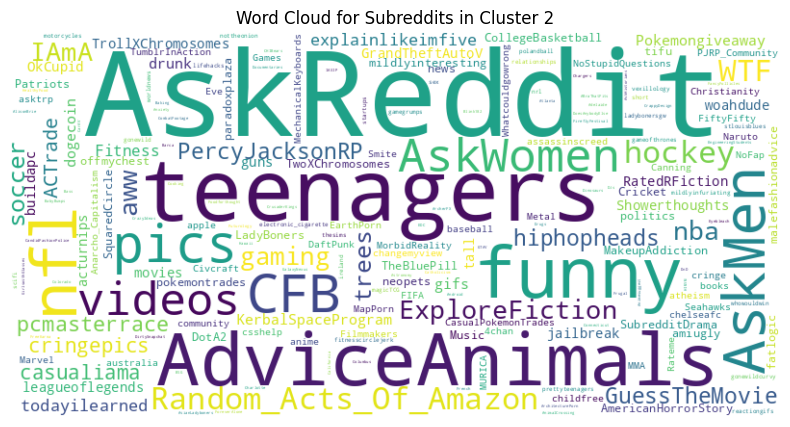

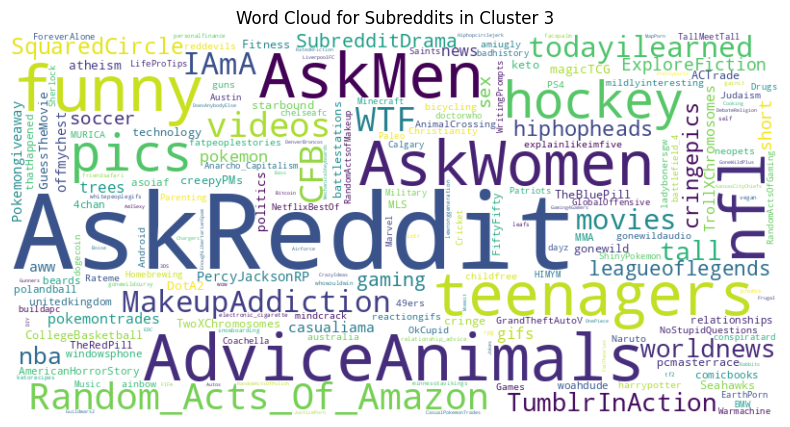

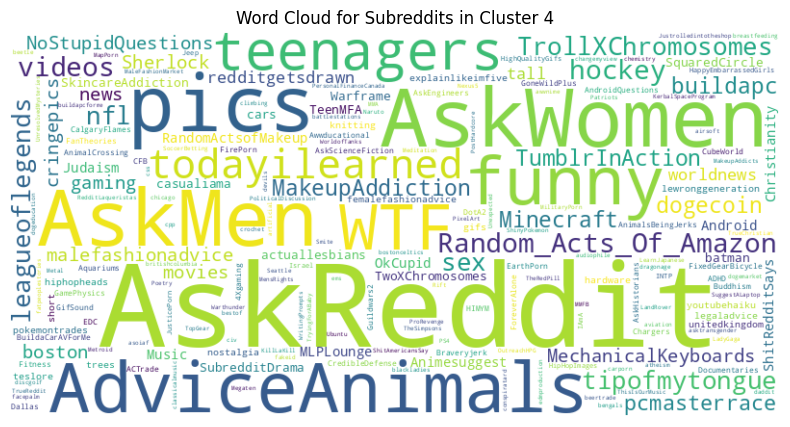

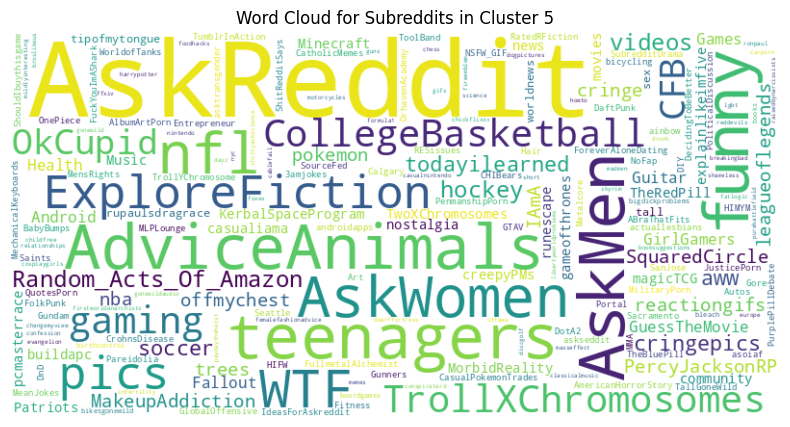

In [39]:
from wordcloud import WordCloud

cluster_subreddit_distribution = sampled_embeddings.groupby(['cluster', 'subreddit']).size().reset_index(name='count')

for cluster_num in range(n_clusters):
    # Filter the dataframe for the current cluster
    cluster_subreddits = cluster_subreddit_distribution[cluster_subreddit_distribution['cluster'] == cluster_num]

    # Create a dictionary of subreddit frequencies
    subreddit_freq_dict = cluster_subreddits.set_index('subreddit')['count'].to_dict()

    # word cloud and show
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    wordcloud.generate_from_frequencies(subreddit_freq_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Subreddits in Cluster {cluster_num}')
    plt.show()


Lastly, we plotted the first two principal components from our PCA to check the spread and overlap of our data points. This visualization helps to infer the level of distinction between the clusters based on the language used in comments.

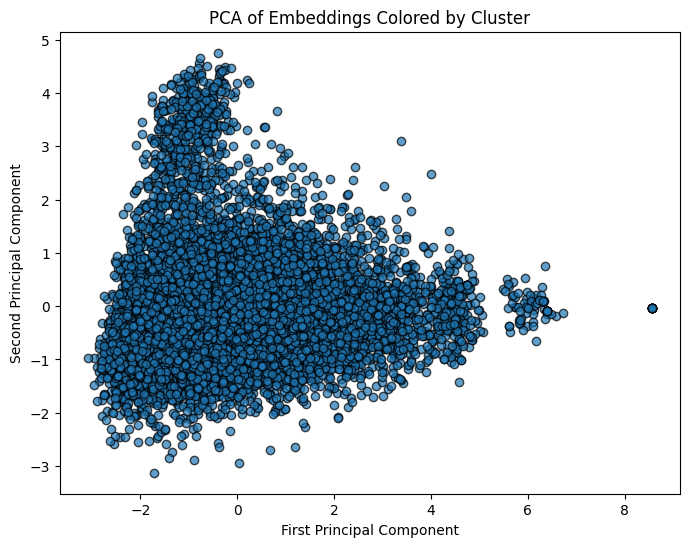

In [41]:

for i in range(X_reduced.shape[1]):
    sampled_embeddings[i] = X_reduced[:, i]


pca1 = sampled_embeddings[0]  # First principal component
pca2 = sampled_embeddings[1]  # Second principal component


# scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca1, pca2, marker='o', alpha=0.7, edgecolor='k')


plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Embeddings Colored by Cluster')


plt.show()


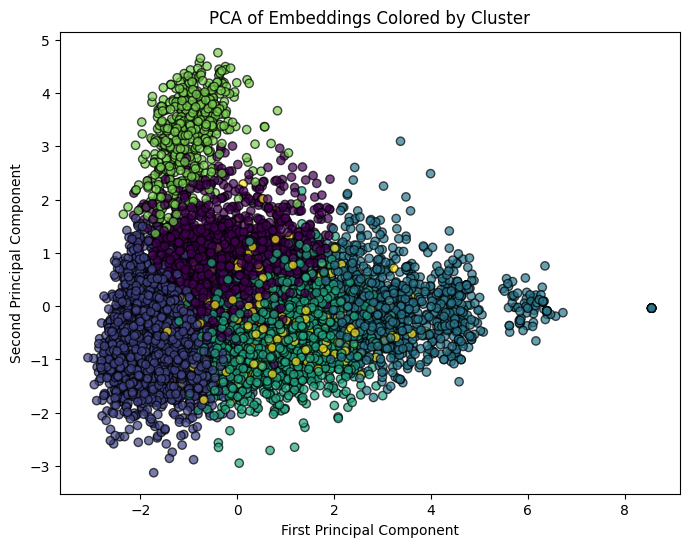

In [42]:

for i in range(X_reduced.shape[1]):
    sampled_embeddings[i] = X_reduced[:, i]


pca1 = sampled_embeddings[0]  # First principal component
pca2 = sampled_embeddings[1]  # Second principal component
clusters = sampled_embeddings['cluster']

# scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca1, pca2, c=clusters, cmap='viridis', marker='o', alpha=0.7, edgecolor='k')


plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Embeddings Colored by Cluster')




# Show the plot
plt.show()
